In [9]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import tree

In [10]:
in_file_name = 'data/runs_ju.tsv'
runs = pd.read_csv(in_file_name, delimiter="\t")
runs = runs.assign(leg_id=runs.leg_nro.astype(str))

In [13]:
runs

,name,year,team_id,team,pace,leg_nro,num_runs,leg_id
0,max peter bejmer,2017,5,IFK GÖTEBORG,5.582,1,3,1
1,max peter bejmer,2016,12,IFK GÖTEBORG,5.608,6,3,6
2,max peter bejmer,2014,141,BROMMA-VÄLLINGBY SOK/JÄRFÄL,7.822,4,3,4
3,johan högstrand,2017,5,IFK GÖTEBORG,5.591,2,4,2
4,johan högstrand,2016,12,IFK GÖTEBORG,5.902,3,4,3
5,johan högstrand,2015,27,IFK GÖTEBORG,6.571,3,4,3
6,johan högstrand,2014,320,MARKBYGDENS OK,6.728,2,4,2
7,vetle ruud bråten,2017,5,IFK GÖTEBORG,5.688,3,4,3
8,vetle ruud bråten,2016,12,IFK GÖTEBORG,5.636,4,4,4
9,vetle ruud bråten,2015,27,IFK GÖTEBORG,5.615,6,4,6


In [54]:
# To disable auto-scrolling, execute this javascript in a notebook cell before other cells are executed:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

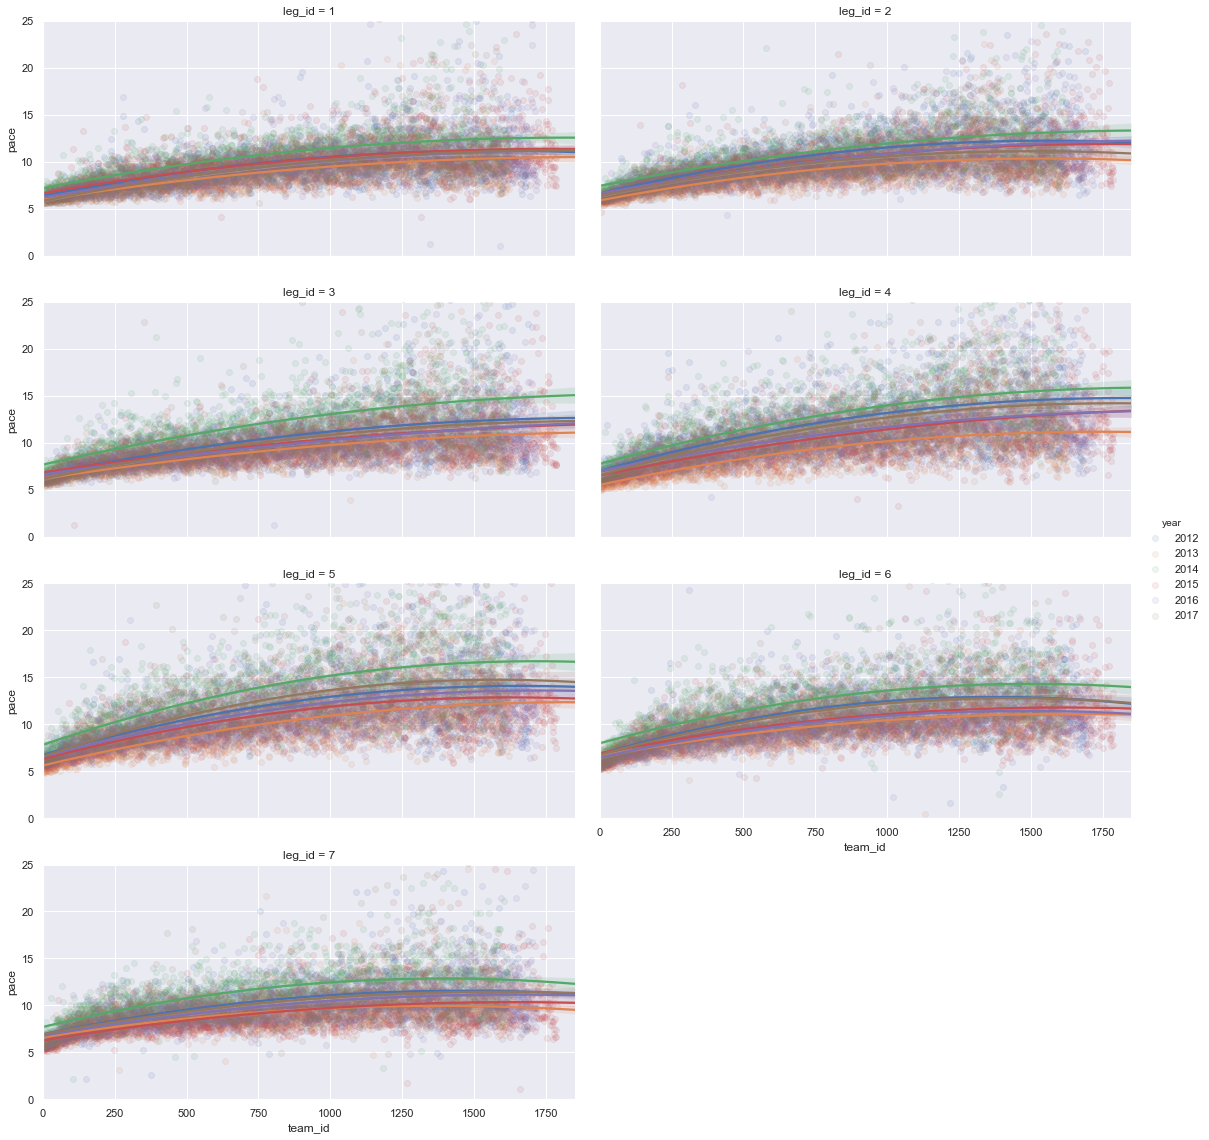

In [100]:
import seaborn as sns
sns.set(rc={})
g = sns.FacetGrid(runs, col="leg_id", hue="year", xlim=(0,1850), ylim=(0,25), height=4, aspect=2, col_wrap=2)
g.map(sns.regplot, "team_id", "pace", scatter_kws={'alpha':0.1}, order=2).add_legend()


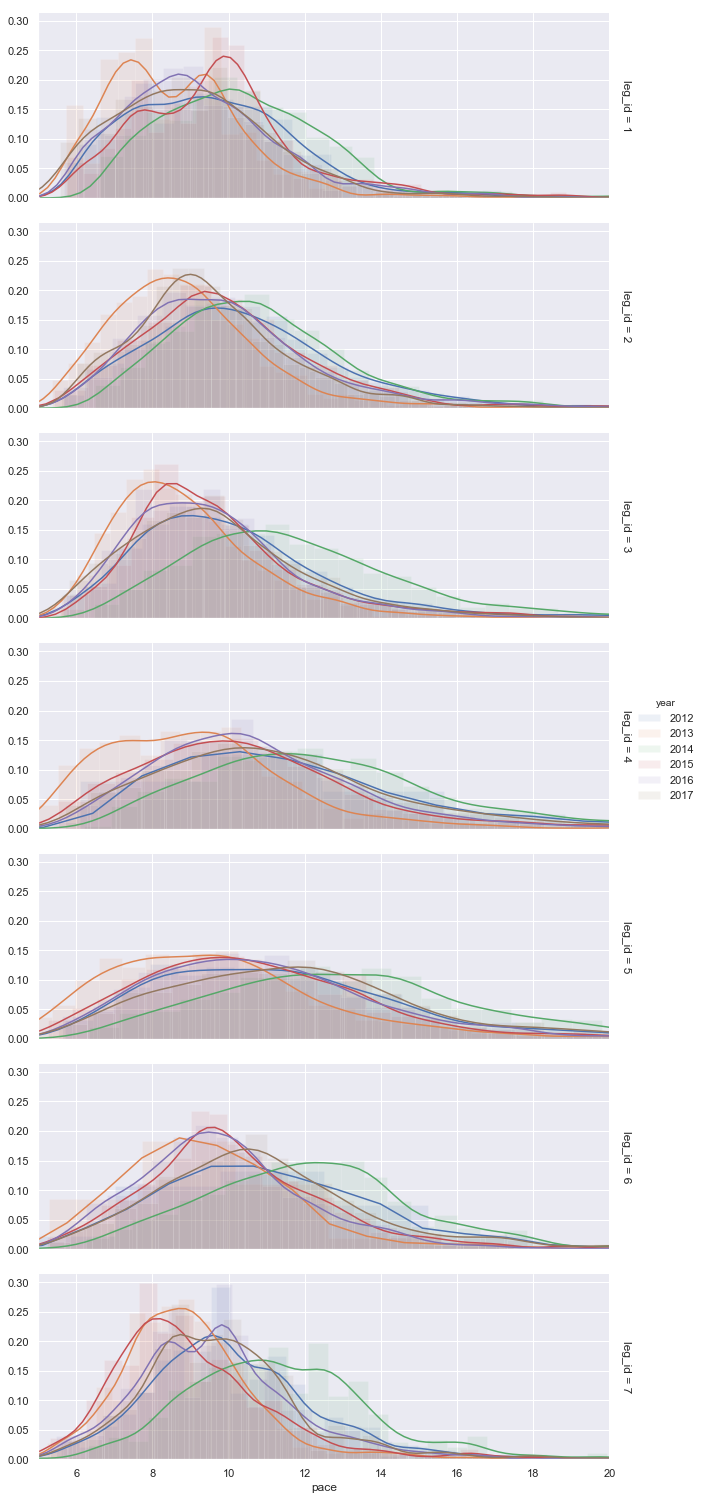

In [102]:
g = sns.FacetGrid(runs, hue="year", row="leg_id",  aspect=3, xlim=(5,20), margin_titles=True, despine=True)
g.map(sns.distplot, "pace", hist_kws={'alpha':0.1}).add_legend()

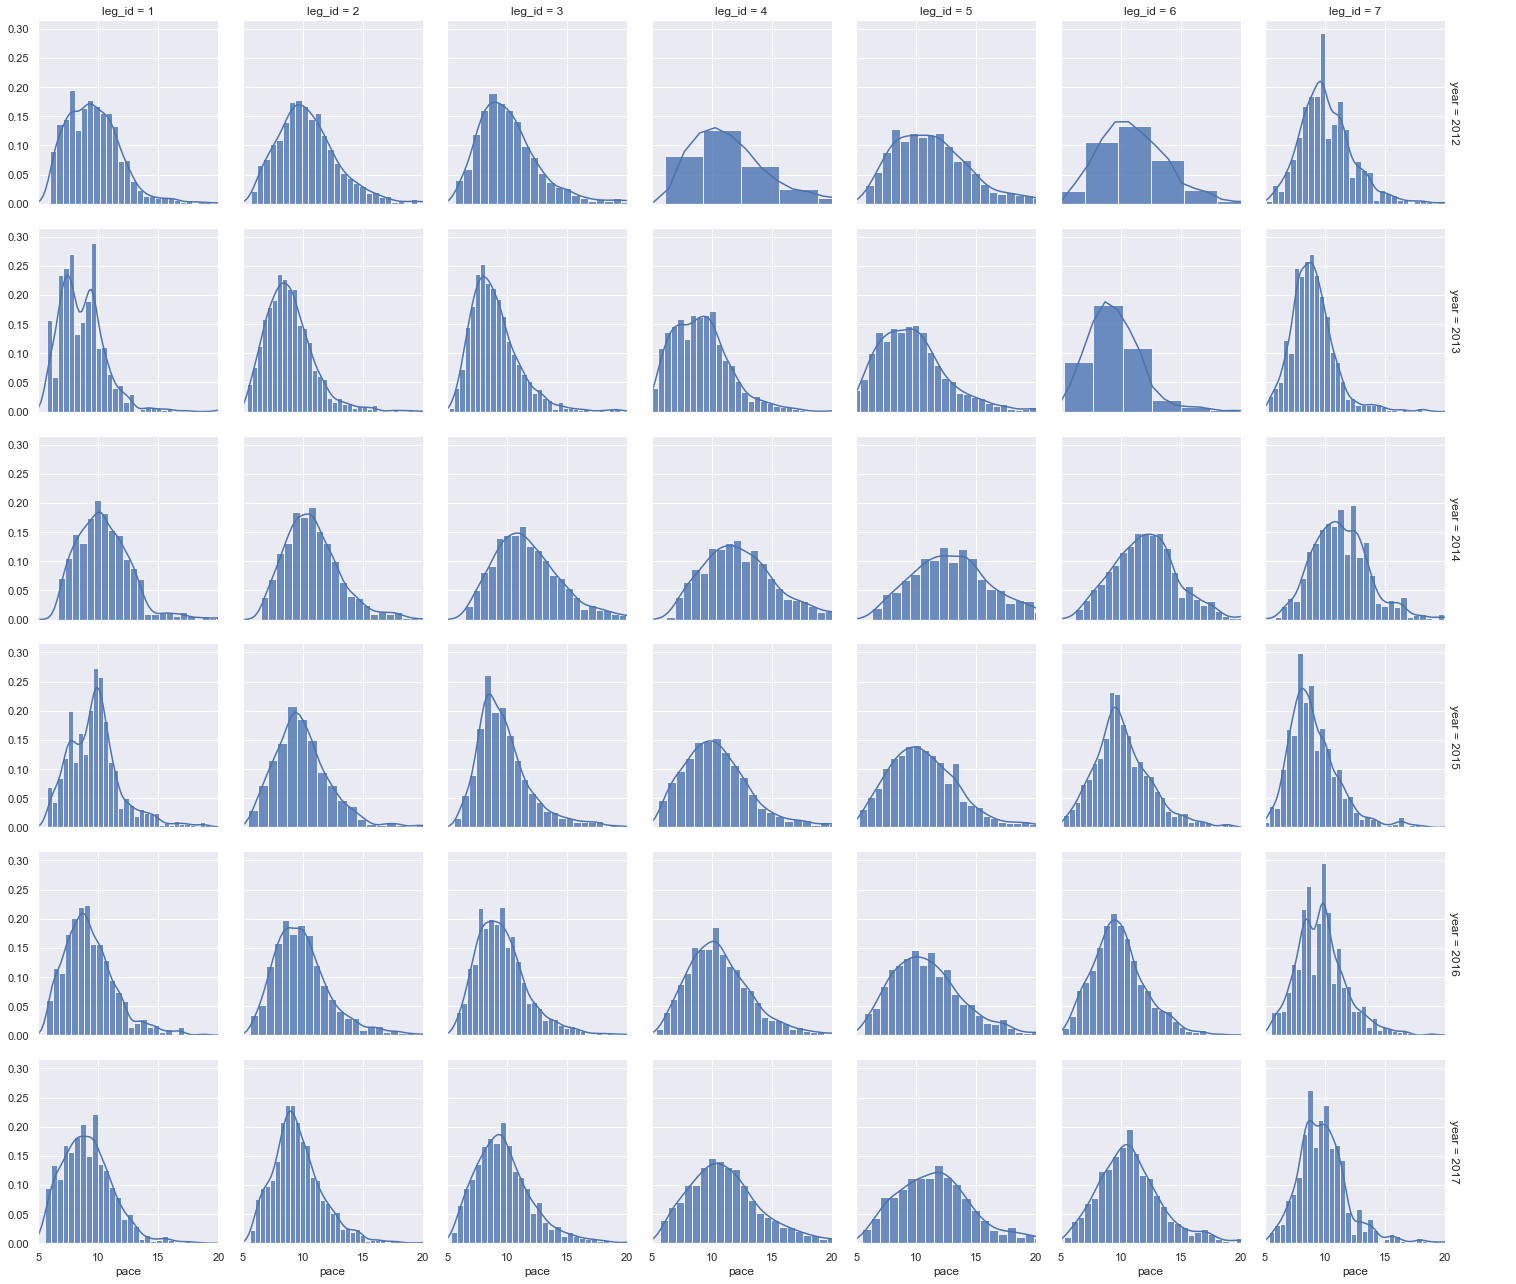

In [104]:
g = sns.FacetGrid(runs, row="year", col="leg_id",  xlim=(5,20), margin_titles=True, despine=True)
g.map(sns.distplot, "pace", hist_kws={'alpha':0.8}).add_legend()

In [110]:
runs_2012_4 = runs[(runs.year == 2012) & (runs.leg_id == "4")]

165.11900000000003

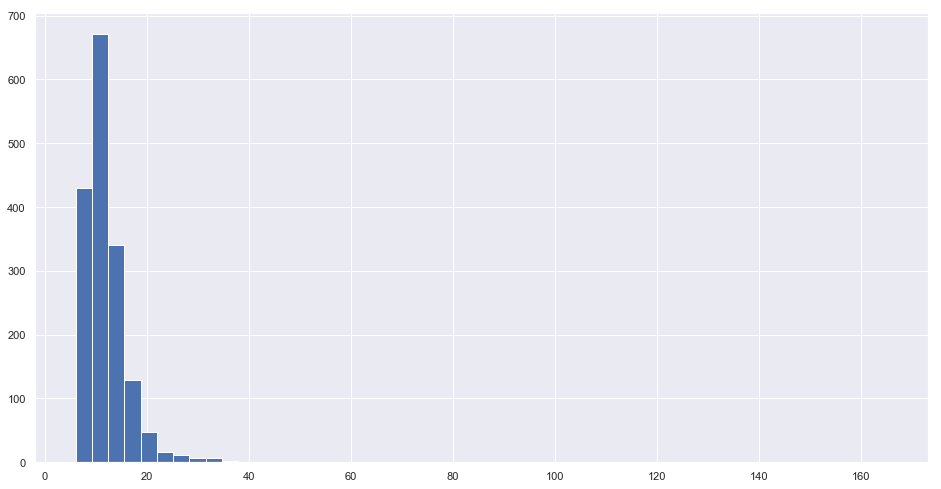

In [114]:
plt.hist(runs_2012_4.pace, bins= 50)
max(runs_2012_4.pace)

In [115]:
runs.sort_values(by="pace")

,name,year,team_id,team,pace,leg_nro,num_runs,leg_id
65195,kari hjulgren,2013,1131,RASTIKARHUT,0.403,6,2,6
35456,tapio patanen,2016,1590,RAJAKYLÄN KUNTOGUBBET,0.974,1,6,1
15815,viviann lindholm,2015,1660,OK DAMLAGET VICTORIOUS SECR,1.108,7,3,7
41031,ben mitchell,2015,107,RAJAMÄEN RYKMENTTI,1.229,3,2,3
50143,heme 1,2016,1347,HELSINGIN METSÄNKÄVIJÄT,1.234,1,1,1
50989,tomi karhukorpi,2016,803,HALSUAN TOIVO,1.255,3,4,3
38183,kaapro häkkinen,2012,1219,ÄKY TÄKY,1.549,6,3,6
12225,kjell karlsson,2015,1265,PARGAS IF,1.710,7,6,7
52747,anna närhi,2014,105,IFK GÖTEBORG,2.130,7,2,7
67914,håvard halvorsen,2012,149,KONGSBERG OL,2.135,7,1,7


In [61]:
sns.set(rc={'figure.figsize':(16,8.27)})
ax = sns.regplot(x="team_id", y="pace", data=runs, 
                 scatter_kws={'alpha':0.1}, 
                 order=6)
ax.set_ylim(0, 35)

TypeError: regplot() got an unexpected keyword argument 'hue'

In [54]:
runs
#x = runs.team_id.values
x = runs.as_matrix(["team_id", "leg_id"])
y = runs.pace.values
print(x) 
#x = x.reshape(len(x), 1)
x = x.reshape(len(x), 2)
y = y.reshape(len(y), 1)

[[5 '1']
 [12 '6']
 [141 '4']
 ...
 [84 '6']
 [27 '4']
 [27 '5']]


In [55]:
x.shape


(64201, 2)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2)

In [72]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
regr.coef_

array([[0.00326566, 0.14133471]])

In [73]:
regr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

ValueError: x and y must be the same size

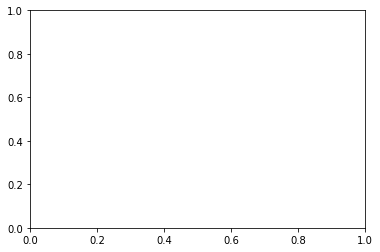

In [58]:


# plot it as in the example at http://scikit-learn.org/
plt.scatter(x_train, y_train,  color='black', alpha=0.01)
plt.plot(x_train, regr.predict(x_train), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [59]:
# Make predictions using the testing set
y_pred = regr.predict(x_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
y_pred

Mean squared error: 6.12
Variance score: 0.31


array([[ 9.24866616],
       [12.72985748],
       [12.3865834 ],
       ...,
       [12.50126143],
       [11.11571107],
       [ 9.39994925]])

In [60]:
rf = RandomForestRegressor(random_state=0, verbose=1)
rf.fit(x_train, y_train.ravel())

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=1, warm_start=False)

In [61]:
# Make predictions using the testing set
rf_y_pred = rf.predict(x_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))


Mean squared error: 7.59
Variance score: 0.14


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


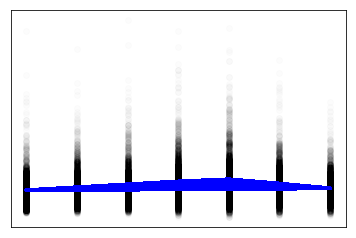

In [31]:
# plot it as in the example at http://scikit-learn.org/
plt.scatter(x_test, y_test,  color='black', alpha=0.01)
plt.plot(x_test, rf.predict(x_test), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [32]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1)
y_rbf_pred = svr_rbf.fit(x_train, y_train.ravel()).predict(x_test)

In [33]:


print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_rbf_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_rbf_pred))


Mean squared error: 8.67
Variance score: 0.02


In [62]:
clf = tree.DecisionTreeRegressor()
clf.fit(x_train, y_train.ravel())
# Make predictions using the testing set
y_clf_pred = clf.predict(x_test)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_clf_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_clf_pred))


Mean squared error: 8.12
Variance score: 0.08


In [71]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x_train, y_train.ravel())
# Make predictions using the testing set
y_ransac_pred = ransac.predict(x_test)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_ransac_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_ransac_pred))


Mean squared error: 6.45
Variance score: 0.27
